In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

2022-07-31 12:05:12.227179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/mpi/lib:
2022-07-31 12:05:12.227203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
demand_supply_monthly_df = pd.read_csv('../../data/cleaned data/demand_supply_monthly.csv')

print('Number of rows and columns:', demand_supply_monthly_df.shape)
demand_supply_monthly_df.head(5)

Number of rows and columns: (122, 17)


,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0000,354.0000,-0.9000,10632.0000,10605.0000,-26.0000,-0.2000,17646.0000,17563.0000,-83.0000,-0.5000,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0000,337.0000,0.0000,10459.0000,10458.0000,-1.0000,0.0000,16906.0000,16906.0000,0.0000,0.0000,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0000,343.0000,-0.3000,10657.0000,10648.0000,-9.0000,-0.1000,17196.0000,17196.0000,0.0000,0.0000,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0000,286.0000,0.0000,8873.0000,8873.0000,1.0000,0.0000,15290.0000,15290.0000,0.0000,0.0000,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0000,245.0000,0.0000,7362.0000,7360.0000,-1.0000,0.0000,13501.0000,13480.0000,-21.0000,-0.2000,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [3]:
demand_supply_monthly_df['date'] = pd.to_datetime(demand_supply_monthly_df['year'].apply(str)+'-'+demand_supply_monthly_df['month'].apply(str)+'-'+str(1), format='%Y-%m-%d')

demand_supply_monthly_df.sort_values('date', inplace=True)
demand_supply_monthly_df.set_index('date', inplace=True)
demand_supply_monthly_df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
date,,,,,,,,,,,,,,,,,
2012-04-01,257.0000,198.0000,-59.0000,7707.0000,5940.0000,-1767.0000,-23.0000,11661.0000,10078.0000,-1583.0000,-14.0000,Monthly Report April 2012,2012,4,2014-07-21,7,2014
2012-05-01,254.0000,222.0000,-32.0000,7605.0000,6649.0000,-956.0000,-13.0000,10968.0000,10491.0000,-477.0000,-4.0000,May 2012 Monthly Report,2012,5,2014-07-21,7,2014
2012-06-01,264.0000,230.0000,-35.0000,7928.0000,6893.0000,-1035.0000,-13.0000,12548.0000,11283.0000,-1265.0000,-10.0000,June 2012 Monthly Report,2012,6,2014-07-21,7,2014
2012-07-01,257.0000,235.0000,-23.0000,7981.0000,7272.0000,-709.0000,-9.0000,11863.0000,11105.0000,-758.0000,-6.0000,July 2012 Monthly Report,2012,7,2014-07-21,7,2014
2012-08-01,253.0000,218.0000,-35.0000,7851.0000,6773.0000,-1078.0000,-14.0000,11914.0000,10751.0000,-1163.0000,-10.0000,August 2012 Monthly Report,2012,8,2014-07-21,7,2014


In [4]:
df= demand_supply_monthly_df[['Peak_Demand_Met5(MW)','year','month']]
df.columns=['peak_demand_met5_mw','year','month']
df['date_time']=df.index
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)

df.head()

,peak_demand_met5_mw,year,month,date_time,quarter
date,,,,,
2012-04-01,10078.0000,2012,4,2012-04-01,2
2012-05-01,10491.0000,2012,5,2012-05-01,2
2012-06-01,11283.0000,2012,6,2012-06-01,2
2012-07-01,11105.0000,2012,7,2012-07-01,3
2012-08-01,10751.0000,2012,8,2012-08-01,3


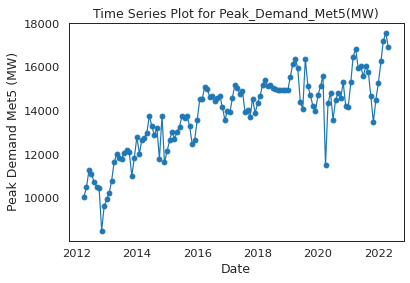

In [5]:

plt.plot(df["peak_demand_met5_mw"], marker='o')

# Labelling 

plt.xlabel("Date")
plt.ylabel("Peak Demand Met5 (MW)")
plt.title("Time Series Plot for Peak_Demand_Met5(MW)")

# Display

plt.show()

In [6]:
stat, p = stats.normaltest(df.peak_demand_met5_mw)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')


Statistics=7.035, p=0.030
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.



Kurtosis of normal distribution: -0.009316878006847773
Skewness of normal distribution: -0.5916885362204893


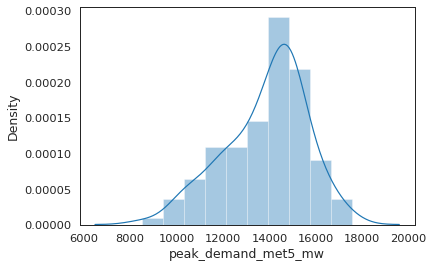

In [7]:
sns.distplot(df.peak_demand_met5_mw);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.peak_demand_met5_mw)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.peak_demand_met5_mw)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

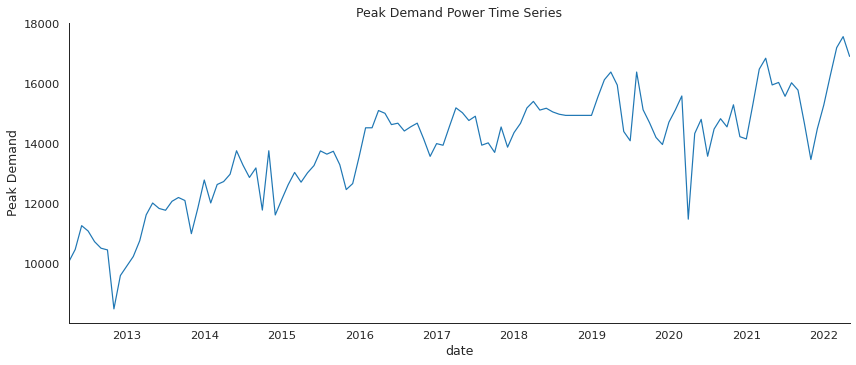

In [8]:
df1=df.loc[:,['peak_demand_met5_mw']]
df1.plot(figsize=(12,5))
plt.ylabel('Peak Demand')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Peak Demand Power Time Series')
sns.despine(top=True)
plt.show();

## Box plot of yearly vs. quarterly Global active power


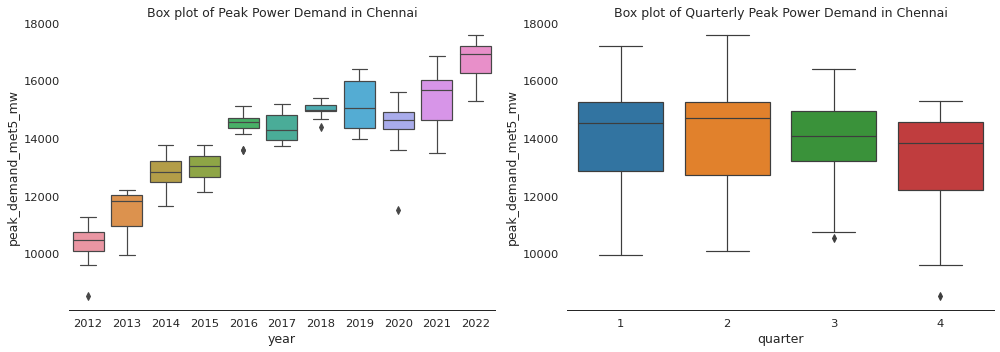

In [9]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="peak_demand_met5_mw", data=df)
plt.xlabel('year')
plt.title('Box plot of Peak Power Demand in Chennai')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="peak_demand_met5_mw", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Peak Power Demand in Chennai')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
peak_demand_met5_mw,122.0000,13849.1016,1771.1750,8518.0000,12732.0000,14225.5000,15007.2500,17563.0000


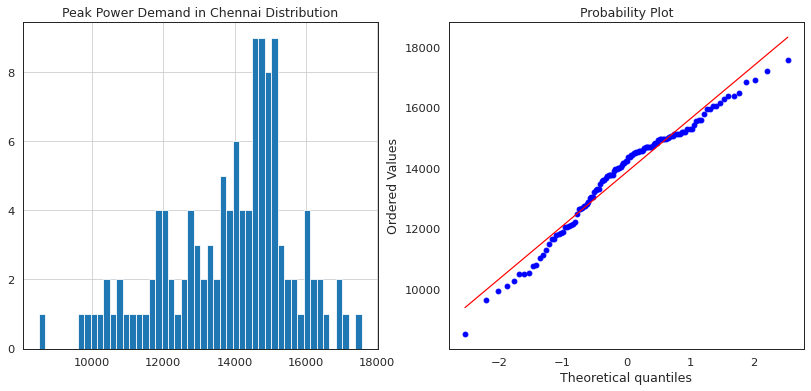

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['peak_demand_met5_mw'].hist(bins=50)
plt.title('Peak Power Demand in Chennai Distribution')

plt.subplot(1,2,2)
stats.probplot(df['peak_demand_met5_mw'], plot=plt);
df1.describe().T


Normal probability plot also shows the data set is far from normally distributed.



### Average Global Active Power resampled over month, quarter and year.


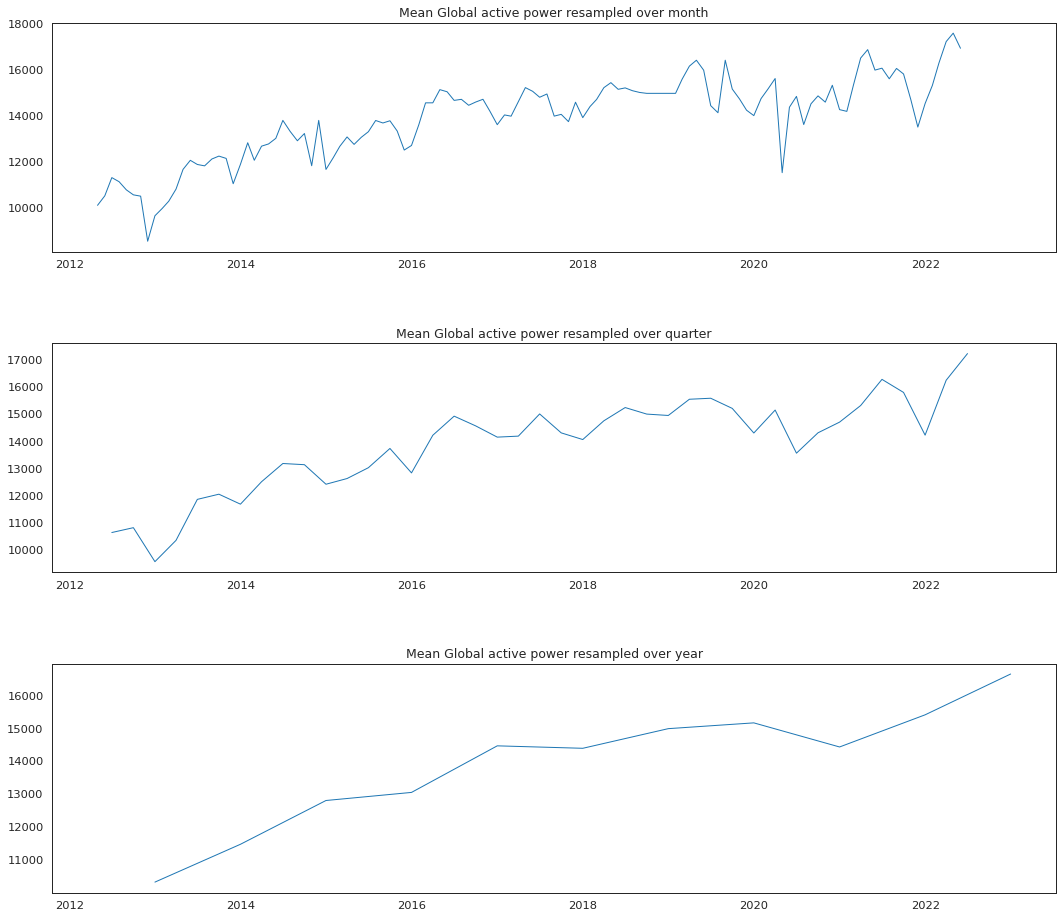

In [11]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax1 = fig.add_subplot(3,1,1)
ax1.plot(df1['peak_demand_met5_mw'].resample('M').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over month')
ax1.tick_params(axis='both', which='major')

ax2  = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(df1['peak_demand_met5_mw'].resample('Q').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over quarter')
ax2.tick_params(axis='both', which='major')

ax3  = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(df1['peak_demand_met5_mw'].resample('A').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over year')
ax3.tick_params(axis='both', which='major');

### Plot mean global active power grouped by year, quarter, and month.


Text(0.5, 1.0, 'Mean Peak power demand by Month')

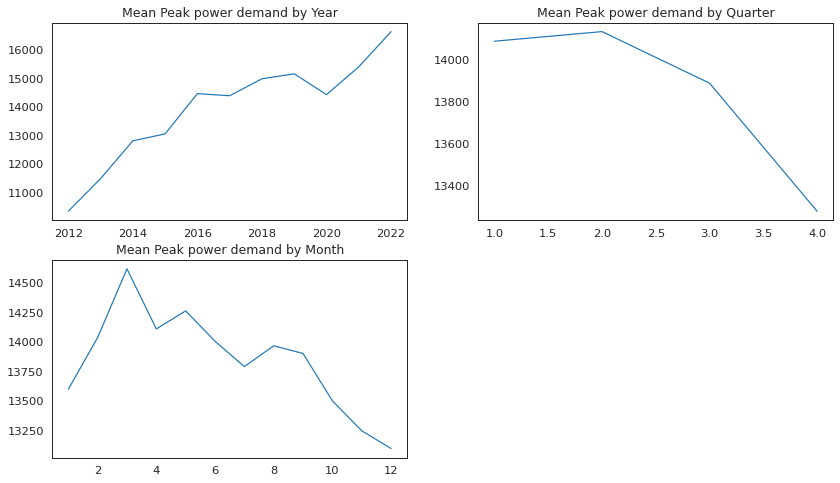

In [12]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').peak_demand_met5_mw.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Peak power demand by Year')

plt.subplot(2,2,2)
df.groupby('quarter').peak_demand_met5_mw.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Peak power demand by Quarter')

plt.subplot(2,2,3)
df.groupby('month').peak_demand_met5_mw.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Peak power demand by Month')


In [13]:
df1.head()

,peak_demand_met5_mw
date,
2012-04-01,10078.0000
2012-05-01,10491.0000
2012-06-01,11283.0000
2012-07-01,11105.0000
2012-08-01,10751.0000


In [14]:
# df2=df1.resample('D', how=np.mean)
df2 = df1.resample('D').agg(np.mean)

In [15]:
df2

,peak_demand_met5_mw
date,
2012-04-01,10078.0000
2012-04-02,NaN
2012-04-03,NaN
2012-04-04,NaN
2012-04-05,NaN
...,...
2022-04-27,NaN
2022-04-28,NaN
2022-04-29,NaN


#### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

#### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [16]:

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

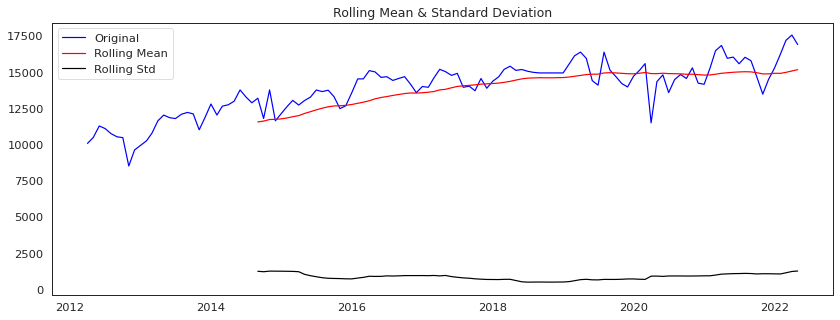

<Results of Dickey-Fuller Test>
Test Statistic                 -2.3598
p-value                         0.1534
#Lags Used                      9.0000
Number of Observations Used   112.0000
Critical Value (1%)            -3.4901
Critical Value (5%)            -2.8877
Critical Value (10%)           -2.5807
dtype: float64


In [17]:
test_stationarity(df2.peak_demand_met5_mw.dropna())


## LSTM

The task here will be to predict values for a timeseries given the history of 2 million minutes of a household's power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minutes.

Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [18]:
dataset = df.peak_demand_met5_mw.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [19]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [20]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [21]:
X_train.shape


(54, 30)

In [22]:
Y_train.shape


(54,)

In [23]:
X_test

array([[0.82189053, 0.6515202 , 0.6174682 , 0.86987287, 0.7313433 ,
        0.6835821 , 0.6296297 , 0.60364836, 0.6855721 , 0.73079044,
        0.781979  , 0.32946378, 0.64400226, 0.69607514, 0.5606412 ,
        0.6603648 , 0.6985075 , 0.66843563, 0.74958545, 0.63239354,
        0.6241017 , 0.74958545, 0.8803759 , 0.9207297 , 0.8224433 ,
        0.8316197 , 0.78065234, 0.8304035 , 0.8035379 , 0.6807075 ],
       [0.6515202 , 0.6174682 , 0.86987287, 0.7313433 , 0.6835821 ,
        0.6296297 , 0.60364836, 0.6855721 , 0.73079044, 0.781979  ,
        0.32946378, 0.64400226, 0.69607514, 0.5606412 , 0.6603648 ,
        0.6985075 , 0.66843563, 0.74958545, 0.63239354, 0.6241017 ,
        0.74958545, 0.8803759 , 0.9207297 , 0.8224433 , 0.8316197 ,
        0.78065234, 0.8304035 , 0.8035379 , 0.6807075 , 0.54859036],
       [0.6174682 , 0.86987287, 0.7313433 , 0.6835821 , 0.6296297 ,
        0.60364836, 0.6855721 , 0.73079044, 0.781979  , 0.32946378,
        0.64400226, 0.69607514, 0.5606412 , 0.

In [24]:
Y_test

array([0.54859036, 0.6614705 , 0.7487009 , 0.85616356, 0.95942515,
       0.99999994], dtype=float32)

In [25]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [26]:
X_train.shape


(54, 1, 30)

In [27]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2022-07-31 12:05:18.485838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/mpi/lib:
2022-07-31 12:05:18.485875: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 12:05:18.485896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lap0002592): /proc/driver/nvidia/version does not exist
2022-07-31 12:05:18.486137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5125 - val_loss: 0.6824
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.4108 - val_loss: 0.5525
Epoch 3/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3312 - val_loss: 0.4379
Epoch 4/100
1/1 [==============================] - 0s 24ms/step - loss: 0.2684 - val_loss: 0.3381
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2061 - val_loss: 0.2529
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1490 - val_loss: 0.1820
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1051 - val_loss: 0.1250
Epoch 8/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0730 - val_loss: 0.0816
Epoch 9/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0408 - val_loss: 0.0511
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0264 - val_loss: 0.0325
Epoch 11/100
1/1 [===

In [29]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

1/1 [==============================] - 0s 16ms/step
Train Mean Absolute Error: 1386.9997640804775
Train Root Mean Squared Error: 1574.5669064972353
Test Mean Absolute Error: 1806.3336867580463
Test Root Mean Squared Error: 2280.3883499395083


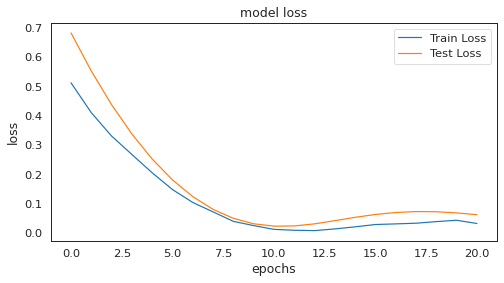

In [30]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [31]:
X_test, Y_test

(array([[[0.82189053, 0.6515202 , 0.6174682 , 0.86987287, 0.7313433 ,
          0.6835821 , 0.6296297 , 0.60364836, 0.6855721 , 0.73079044,
          0.781979  , 0.32946378, 0.64400226, 0.69607514, 0.5606412 ,
          0.6603648 , 0.6985075 , 0.66843563, 0.74958545, 0.63239354,
          0.6241017 , 0.74958545, 0.8803759 , 0.9207297 , 0.8224433 ,
          0.8316197 , 0.78065234, 0.8304035 , 0.8035379 , 0.6807075 ]],
 
        [[0.6515202 , 0.6174682 , 0.86987287, 0.7313433 , 0.6835821 ,
          0.6296297 , 0.60364836, 0.6855721 , 0.73079044, 0.781979  ,
          0.32946378, 0.64400226, 0.69607514, 0.5606412 , 0.6603648 ,
          0.6985075 , 0.66843563, 0.74958545, 0.63239354, 0.6241017 ,
          0.74958545, 0.8803759 , 0.9207297 , 0.8224433 , 0.8316197 ,
          0.78065234, 0.8304035 , 0.8035379 , 0.6807075 , 0.54859036]],
 
        [[0.6174682 , 0.86987287, 0.7313433 , 0.6835821 , 0.6296297 ,
          0.60364836, 0.6855721 , 0.73079044, 0.781979  , 0.32946378,
          0.

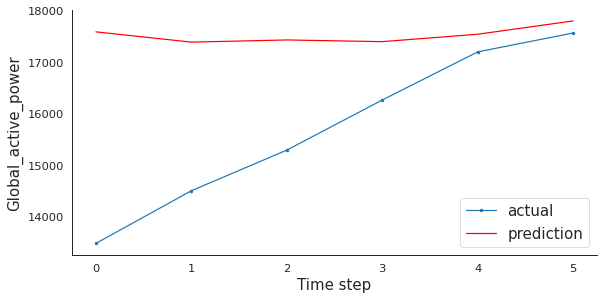

In [32]:
aa=[x for x in range(6)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:6], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:6], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();